### Analyse features as geodesic distance from lesion

In [1]:
from meld_classifier.paths import BASE_PATH, EXPERIMENT_PATH
from meld_classifier.meld_cohort import MeldCohort, MeldSubject
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import potpourri3d as pp3d
from collections import defaultdict


Setting BASE_PATH to /rds/project/kw350/rds-kw350-meld/meld_data/Data/
Setting EXPERIMENT_PATH to /rds/project/kw350/rds-kw350-meld/experiments/kw350


In [2]:
#load cohort
site_codes=['H2', 'H3','H4','H5','H6','H7','H9','H10','H11','H12','H14','H15','H16','H17','H18','H19',
                  'H21','H23','H24','H26']
c= MeldCohort(hdf5_file_root='{site_code}_{group}_featurematrix_combat_6.hdf5', dataset=None)
listids = c.get_subject_ids(site_codes=site_codes, group='patient', lesional_only=True)

In [3]:
len(listids)

545

In [21]:
# features to include

features=[
           '.inter_z.intra_z.combat.on_lh.thickness.sm10.mgh',
           '.inter_z.intra_z.combat.on_lh.w-g.pct.sm10.mgh',
           '.inter_z.intra_z.combat.on_lh.pial.K_filtered.sm20.mgh',
           '.inter_z.intra_z.combat.on_lh.curv.sm5.mgh',
           '.inter_z.intra_z.combat.on_lh.sulc.sm5.mgh',
#            '.inter_z.intra_z.combat.on_lh.gm_FLAIR_0.25.sm10.mgh',
#            '.inter_z.intra_z.combat.on_lh.gm_FLAIR_0.5.sm10.mgh',
           '.inter_z.intra_z.combat.on_lh.gm_FLAIR_0.75.sm10.mgh',
           '.inter_z.intra_z.combat.on_lh.gm_FLAIR_0.sm10.mgh',
#            '.inter_z.intra_z.combat.on_lh.wm_FLAIR_0.5.sm10.mgh',
            '.inter_z.intra_z.combat.on_lh.wm_FLAIR_1.sm10.mgh']

feature_names = {'.inter_z.intra_z.combat.on_lh.gm_FLAIR_0.75.sm10.mgh':'FLAIR GM 75% ', 
            '.inter_z.intra_z.combat.on_lh.w-g.pct.sm10.mgh':'Grey-white contrast' , 
            '.inter_z.intra_z.combat.on_lh.pial.K_filtered.sm20.mgh':'Intrinsic curvature',
            '.inter_z.intra_z.combat.on_lh.thickness.sm10.mgh':'Cortical thickness',
            '.inter_z.intra_z.combat.on_lh.wm_FLAIR_0.5.sm10.mgh':'FLAIR WM 0.5mm ',
            '.inter_z.intra_z.combat.on_lh.wm_FLAIR_1.sm10.mgh':'FLAIR WM 1mm ',
            '.inter_z.intra_z.combat.on_lh.gm_FLAIR_0.25.sm10.mgh':'FLAIR GM 25% ',
            '.inter_z.intra_z.combat.on_lh.gm_FLAIR_0.5.sm10.mgh':'FLAIR GM 50%',
            '.inter_z.intra_z.combat.on_lh.gm_FLAIR_0.sm10.mgh':'FLAIR GM-WM',
            '.inter_z.intra_z.combat.on_lh.curv.sm5.mgh' : 'Mean curvature',
           '.inter_z.intra_z.combat.on_lh.sulc.sm5.mgh' : 'Sulcal depth',
                }

In [5]:
# define functions
def flatten(t):
    return [item for sublist in t for item in sublist]


# create solver for geodesic distance
solver = pp3d.MeshHeatMethodDistanceSolver(c.surf['coords'], c.surf['faces'])

In [7]:
vals_dist= defaultdict(list)
included_subjects=[]
vals_list = []

for k,subject in enumerate(listids):
    subj = MeldSubject(subject, cohort=c)
    hemi = subj.get_lesion_hemisphere()
    if hemi:
        lesion = np.round(subj.load_feature_values(hemi=hemi, feature=".on_lh.lesion.mgh")[:])
        non_lesion_and_neighbours=flatten(np.array(c.neighbours)[lesion==0])
        lesion_boundary_vertices=np.setdiff1d(non_lesion_and_neighbours,np.where(lesion==0)[0])
        #calculate distance from boundary vertices
        dist_lesion = solver.compute_distance_multisource(lesion_boundary_vertices)
        #flip sign for distances inside the lesion
        dist_lesion[lesion>0]=-dist_lesion[lesion>0]
        #create array distance
        dist = np.array(np.linspace(0,100, 101))
        #find indexes of vertices at each distance of the lesion
        dist_index = [np.where((dist_lesion>=i) & (dist_lesion <i+1)) for i in dist]
        
        #get absolute z-score value feature
        for i, feature in enumerate(features): 
            vals = abs(subj.load_feature_values(feature, hemi=hemi))
            if vals.any()==0 :
                pass
            else:
                included_subjects.append(subject)
                #get the array of features values at different distance 
                vals_dist[feature].append(np.array([vals[dist_index[i]] for i,_ in enumerate(dist)]))
                        


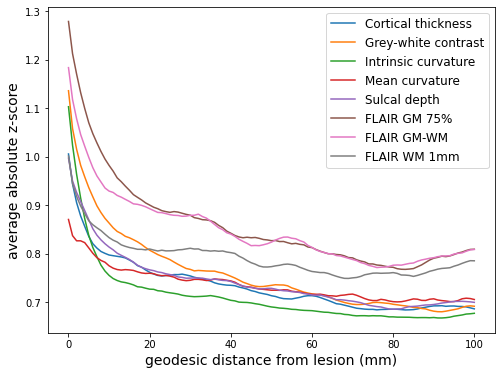

In [22]:
# compute average of all vertices at geodesic distance from lesion 

plt.figure(figsize=[8,6])

for feature in features : 
    dist_from_lesion = np.array(vals_dist[feature])
    data = [np.concatenate(dist_from_lesion[:,i], axis=0) for i,_ in enumerate(dist)]
    data_mean = [data[i].mean() for i,_ in enumerate(dist)]
    plt.plot(dist, data_mean, label = feature_names[feature])
    plt.xlabel('geodesic distance from lesion (mm)', fontsize=14)
    plt.ylabel('average absolute z-score', fontsize=14)
plt.legend(bbox_to_anchor =(1, 1),  fontsize=12)


output_path = '/rds/user/co-ripa1/hpc-work/processes/20210712_MELDpaperFigures/'
plt.savefig(os.path.join(output_path, 'feature_geodesic_distance.png'), dpi=96, transparent =True)

In [ ]:
#OLD
# compute mean of subject mean feature at geodesic distance from lesion
data_mean = np.array(vals_mean_dist).std(axis=0)
plt.plot(dist, data_mean)
plt.xlabel('geodesic distance from lesion (mm)')
plt.ylabel('z-score feature')
plt.title(feature)

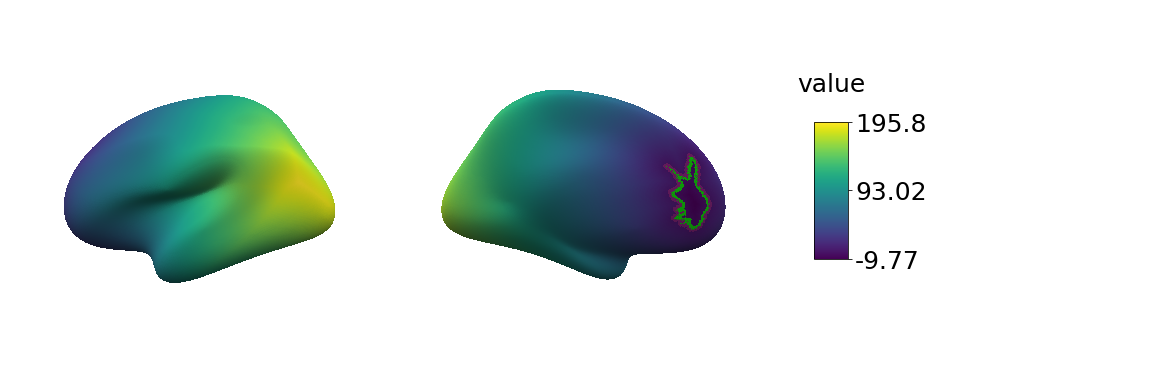

In [36]:
from matplotlib_surface_plotting import plot_surf
plot_surf(c.surf['coords'],c.surf['faces'], dist_lesion, parcel=lesion,
        rotate=[90,270])

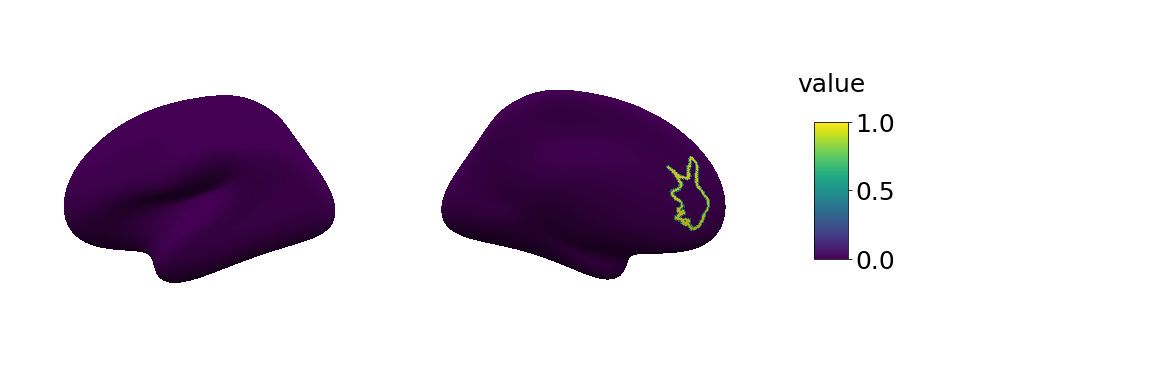

In [38]:
mask = (dist_lesion<=1)&(dist_lesion>=-1)
plot_surf(c.surf['coords'],c.surf['faces'], mask*1, parcel=lesion,
        rotate=[90,270])

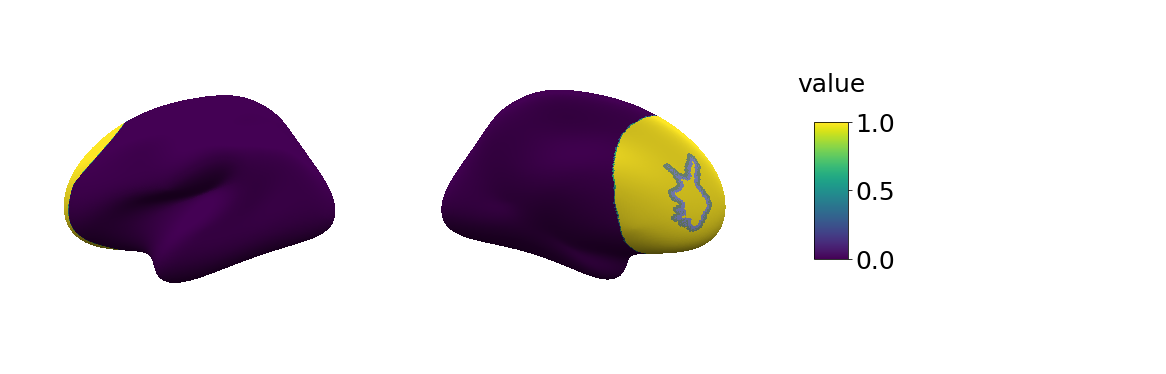

In [39]:
mask = dist_lesion<40
plot_surf(c.surf['coords'],c.surf['faces'], mask*1, parcel=lesion, rotate=[90,270])

In [59]:
c.surf['coords'].shape

(163842, 3)

In [81]:
boundary.shape

(293804,)

In [82]:
import nibabel as nb
mask = dist_lesion<40
surf=nb.load('/rds/user/co-ripa1/hpc-work/scripts/matplotlib_surface_plotting/data/fs_LR.32k.L.flat.surf.gii')
vertices,faces = surf.darrays[0].data,surf.darrays[1].data
plot_surf(vertices, faces, boundary, flat_map=True, base_size=10)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 32492 but corresponding boolean dimension is 163842

In [23]:
import meld_classifier.meld_plotting as mpt
boundary_hemi = c.split_hemispheres(np.array(boundary))['right']
lesion_hemis = np.zeros(len(boundary))
mpt.plot_single_subject(
                [boundary_hemi],
                lesion,
                ['boundary zone']
            )

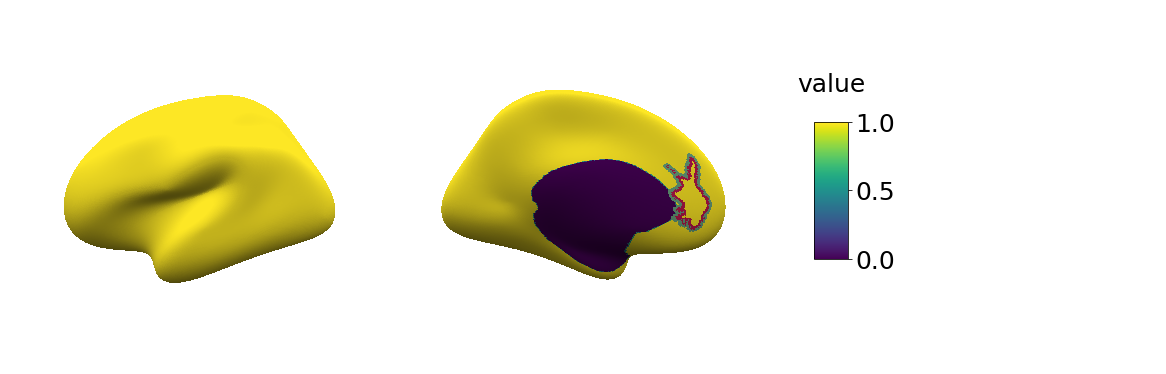

In [34]:
boundary_hemi =c.split_hemispheres(np.array(boundary))
plot_surf(c.surf['coords'],c.surf['faces'], boundary_hemi['left'], parcel=lesion,
        rotate=[90,270])

SyntaxError: unexpected EOF while parsing (<ipython-input-38-76bbb6c38bf8>, line 1)

In [36]:
boundary_hemi['left'].shape

(163842,)

In [37]:
lesion.shape

(163842,)